1. Procesamiento de las imagenes

In [ ]:
!pip install mediapipe

In [ ]:
import os
import cv2
import numpy as np
import mediapipe as mp

# 1. Montar Google Drive (en Colab)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 2. Parámetros y directorios
base_dir = '/content/drive/MyDrive/Proyecto_deteccion_caidas/caidas/camara_0'
window_size = 30  # tamaño de cada ventana (frames)
target_size = (256, 256)  # ancho x alto para redimensionar

# 3. Inicializar MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)

# 4. Diccionario para almacenar ventanas de keypoints por video
dataset = {}

# 5. Procesar cada carpeta video1 ... video30
for vid in range(1, 31):
    folder_name = f'video{vid}'
    folder_path = os.path.join(base_dir, folder_name)
    if not os.path.isdir(folder_path):
        print(f'[Aviso] Carpeta no encontrada: {folder_path}')
        continue

    # 5.1 Listar imágenes en orden
    frames = sorted([f for f in os.listdir(folder_path) if f.lower().endswith('.png')])

    # 5.2 Extraer keypoints secuencialmente
    keypoints_seq = []
    for fname in frames:
        # Leer en BGR, redimensionar, convertir a RGB uint8
        img_bgr = cv2.imread(os.path.join(folder_path, fname))
        img_resized = cv2.resize(img_bgr, target_size)
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

        # Procesar con MediaPipe (espera uint8)
        results = pose.process(img_rgb)
        if results.pose_landmarks:
            kp = np.array([[lm.x, lm.y] for lm in results.pose_landmarks.landmark], dtype=np.float32).flatten()
        else:
            kp = np.zeros(33 * 2, dtype=np.float32)
        keypoints_seq.append(kp)

    keypoints_seq = np.stack(keypoints_seq)  # (num_frames, 66)

    # 5.3 Construir ventanas de keypoints
    num_windows = keypoints_seq.shape[0] - window_size + 1
    windows = []
    for start in range(num_windows):
        window_kp = keypoints_seq[start:start + window_size]  # (30, 66)
        windows.append(window_kp)
    dataset[folder_name] = np.stack(windows)  # (num_windows, 30, 66)
    print(f'{folder_name}: {dataset[folder_name].shape[0]} ventanas procesadas.')

# dataset contiene para cada video un array (num_windows, 30, 66) listo para etiquetar y separar.



Mounted at /content/drive
video1: 123 ventanas procesadas.
video2: 81 ventanas procesadas.
video3: 186 ventanas procesadas.
video4: 67 ventanas procesadas.
video5: 122 ventanas procesadas.
video6: 71 ventanas procesadas.
video7: 127 ventanas procesadas.
video8: 62 ventanas procesadas.
video9: 156 ventanas procesadas.
video10: 101 ventanas procesadas.
video11: 101 ventanas procesadas.
video12: 81 ventanas procesadas.
video13: 56 ventanas procesadas.
video14: 32 ventanas procesadas.
video15: 42 ventanas procesadas.
video16: 26 ventanas procesadas.
video17: 66 ventanas procesadas.
video18: 36 ventanas procesadas.
video19: 71 ventanas procesadas.
video20: 81 ventanas procesadas.
video21: 26 ventanas procesadas.
video22: 27 ventanas procesadas.
video23: 46 ventanas procesadas.
video24: 31 ventanas procesadas.
video25: 56 ventanas procesadas.
video26: 32 ventanas procesadas.
video27: 63 ventanas procesadas.
video28: 37 ventanas procesadas.
video29: 70 ventanas procesadas.
video30: 41 ventana

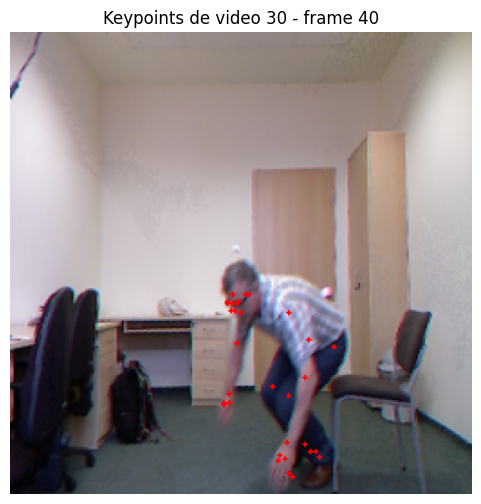

In [ ]:
import matplotlib.pyplot as plt

# 1. Parámetros
video_num = 30
frame_idx =  40 # imagen 14
video_folder = f'video{video_num}'
img_name = f'{video_folder}_{frame_idx:03d}.png'  # → 'video3_014.png'
img_path = os.path.join(base_dir, video_folder, img_name)

# 2. Leer imagen original y preprocesarla
img_bgr = cv2.imread(img_path)
img_resized = cv2.resize(img_bgr, target_size)
img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

# 3. Procesar con MediaPipe
results = pose.process(img_rgb)

# 4. Dibujar keypoints
annotated_img = img_rgb.copy()
if results.pose_landmarks:
    for lm in results.pose_landmarks.landmark:
        x = int(lm.x * target_size[0])
        y = int(lm.y * target_size[1])
        cv2.circle(annotated_img, (x, y), 1, (255, 0, 0), -1)
else:
    print("No se detectaron keypoints en esta imagen.")

# 5. Visualizar
plt.figure(figsize=(6, 6))
plt.imshow(annotated_img)
plt.axis('off')
plt.title(f'Keypoints de video {video_num} - frame {frame_idx}')
plt.show()


In [ ]:
import os
import cv2
import mediapipe as mp

# —————————————————————————
# Parámetros de entrada/salida
# —————————————————————————
input_video_path  = 'jaime_detection.mp4'             # Tu video original
output_video_path = 'jaime_keypoints_v2.mp4'          # Salida con keypoints conectados

# —————————————————————————
# Inicialización MediaPipe Pose y Drawing
# —————————————————————————
mp_pose    = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose       = mp_pose.Pose(static_image_mode=False,
                         model_complexity=1,
                         enable_segmentation=False,
                         min_detection_confidence=0.5,
                         min_tracking_confidence=0.5)

# —————————————————————————
# Abrir video y leer propiedades
# —————————————————————————
cap = cv2.VideoCapture(input_video_path)
if not cap.isOpened():
    raise IOError(f"No se pudo abrir el video {input_video_path}")

fps_orig = cap.get(cv2.CAP_PROP_FPS)
w_orig   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h_orig   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Intercambiamos ancho/alto por la rotación 90°
w_rot, h_rot = h_orig, w_orig
# Reducimos la velocidad a la mitad
fps_out = fps_orig / 2.0

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out    = cv2.VideoWriter(output_video_path,
                         fourcc,
                         fps_out,
                         (w_rot, h_rot))

# —————————————————————————
# Bucle de procesamiento
# —————————————————————————
frame_idx = 0
while True:
    ret, frame_bgr = cap.read()
    if not ret:
        break

    # 1) Rotar 90° CW para corregir orientación
    frame_bgr = cv2.rotate(frame_bgr, cv2.ROTATE_90_CLOCKWISE)

    # 2) Convertir BGR → RGB
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

    # 3) Extraer keypoints
    results = pose.process(frame_rgb)

    # 4) Dibujar esqueleto sobre copia
    annotated = frame_bgr.copy()
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            annotated,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(0,255,0), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(0,0,255), thickness=2)
        )

    # 5) Escribir frame anotado
    out.write(annotated)

    frame_idx += 1
    if frame_idx % 100 == 0:
        print(f'Procesados {frame_idx} frames…')

# —————————————————————————
# Limpieza
# —————————————————————————
cap.release()
out.release()
pose.close()

print(f'\n✅ Hecho: "{output_video_path}" generado con el esqueleto de keypoints, orientación corregida y velocidad al 50%.')


Procesados 100 frames…

✅ Hecho: "jaime_keypoints_v2.mp4" generado con el esqueleto de keypoints, orientación corregida y velocidad al 50%.


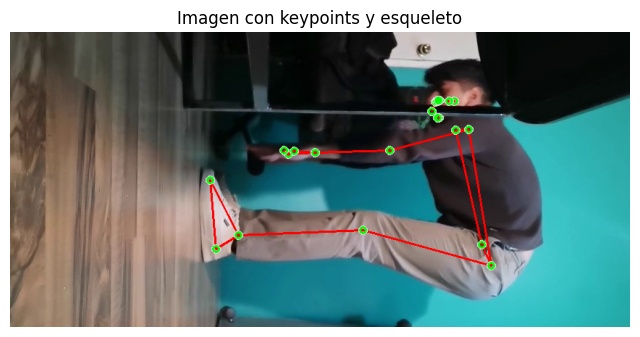

In [ ]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

# —————————————————————————
# Parámetros de entrada/salida
# —————————————————————————
input_image_path  = 'samuel_detection_3.png'           # Ruta a tu imagen de entrada

# —————————————————————————
# Inicialización MediaPipe Pose y Drawing
# —————————————————————————
mp_pose    = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

pose = mp_pose.Pose(static_image_mode=True,
                    model_complexity=1,
                    enable_segmentation=False,
                    min_detection_confidence=0.5)

# —————————————————————————
# Leer y procesar imagen
# —————————————————————————
# 1) Leer la imagen en BGR
img_bgr = cv2.imread(input_image_path)
if img_bgr is None:
    raise IOError(f"No se pudo abrir la imagen {input_image_path}")

# 2) Rotar 90° CW si la imagen viene girada
img_bgr = cv2.rotate(img_bgr, cv2.ROTATE_90_CLOCKWISE)

# 3) Convertir a RGB para MediaPipe
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# 4) Procesar con Pose
results = pose.process(img_rgb)

# —————————————————————————
# Dibujar el esqueleto sobre la imagen
# —————————————————————————
annotated = img_bgr.copy()
if results.pose_landmarks:
    mp_drawing.draw_landmarks(
        annotated,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(0,255,0), thickness=2, circle_radius=4),
        mp_drawing.DrawingSpec(color=(0,0,255), thickness=2)
    )
else:
    print("⚠️ No se detectaron keypoints en la imagen.")

# —————————————————————————
# Mostrar con Matplotlib
# —————————————————————————
# Convertir a RGB para plt.imshow
annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.imshow(annotated_rgb)
plt.axis('off')
plt.title('Imagen con keypoints y esqueleto')
plt.show()

# Cerrar pose
pose.close()


In [ ]:
import numpy as np
# Tuplas proporcionadas
video_infos = [
    (1, 92, 152),
    (2, 59, 110),
    (3, 165, 215),
    (4, 37, 96),
    (5, 100, 151),
    (6, 40, 100),
    (7, 102, 156),
    (8, 50, 91),
    (9, 140, 185),
    (10, 65, 130),
    (11, 67, 130),
    (12, 54, 110),
    (13, 68, 85),
    (14, 40, 61),
    (15, 50, 71),
    (16, 40, 55),
    (17, 77, 95),
    (18, 43, 65),
    (19, 53, 100),
    (20, 45, 110),
    (21, 45, 55),
    (22, 30, 56),
    (23, 50, 75),
    (24, 35, 60),
    (25, 65, 85),
    (26, 37, 61),
    (27, 75, 92),
    (28, 50, 66),
    (29, 75, 99),
    (30, 50, 70),
]

def create_window_labels(video_infos, window_size):
    """
    Crea etiquetas para ventanas de keypoints, marcando 1 si la ventana incluye o va después del inicio de una caída.

    Args:
        video_infos (list of tuples): (video_id, fall_frame, total_frames)
        window_size (int): Número de frames por ventana

    Returns:
        dict: Clave = video_id, Valor = np.array de etiquetas (0/1)
    """
    labels_dict = {}
    for video_id, fall_frame, total_frames in video_infos:
        num_windows = max(total_frames - window_size + 1, 0)

        # Índice de la primera ventana donde la caída puede estar completamente incluida o empezar
        fall_window_idx = max(fall_frame - window_size + 1, 0)

        labels = np.array([
            0 if i < fall_window_idx else 1
            for i in range(num_windows)
        ], dtype=int)

        labels_dict[video_id] = labels

    return labels_dict

# Ejecutar
window_size = 30
labels = create_window_labels(video_infos, window_size)

# Mostrar resumen por video
for vid in sorted(labels):
    lab = labels[vid]
    print(f"Video{vid}: {len(lab)} ventanas -> {lab.sum()} con caída, {len(lab) - lab.sum()} sin caída")


Video1: 123 ventanas -> 60 con caída, 63 sin caída
Video2: 81 ventanas -> 51 con caída, 30 sin caída
Video3: 186 ventanas -> 50 con caída, 136 sin caída
Video4: 67 ventanas -> 59 con caída, 8 sin caída
Video5: 122 ventanas -> 51 con caída, 71 sin caída
Video6: 71 ventanas -> 60 con caída, 11 sin caída
Video7: 127 ventanas -> 54 con caída, 73 sin caída
Video8: 62 ventanas -> 41 con caída, 21 sin caída
Video9: 156 ventanas -> 45 con caída, 111 sin caída
Video10: 101 ventanas -> 65 con caída, 36 sin caída
Video11: 101 ventanas -> 63 con caída, 38 sin caída
Video12: 81 ventanas -> 56 con caída, 25 sin caída
Video13: 56 ventanas -> 17 con caída, 39 sin caída
Video14: 32 ventanas -> 21 con caída, 11 sin caída
Video15: 42 ventanas -> 21 con caída, 21 sin caída
Video16: 26 ventanas -> 15 con caída, 11 sin caída
Video17: 66 ventanas -> 18 con caída, 48 sin caída
Video18: 36 ventanas -> 22 con caída, 14 sin caída
Video19: 71 ventanas -> 47 con caída, 24 sin caída
Video20: 81 ventanas -> 65 con c

In [ ]:
print(labels)

{1: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 2: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 3: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

In [ ]:
import os
import cv2
import numpy as np
import mediapipe as mp
from sklearn.model_selection import train_test_split
X_list, y_list = [], []
for vid in range(1, 31):
    k = f'video{vid}'
    if k in dataset and vid in labels:
        if dataset[k].shape[0] != labels[vid].shape[0]:
            print(f'[Warning] tamaño distinto en {k}')
            m = min(dataset[k].shape[0], labels[vid].shape[0])
            X_list.append(dataset[k][:m])
            y_list.append(labels[vid][:m])
        else:
            X_list.append(dataset[k])
            y_list.append(labels[vid])

X = np.vstack(X_list)   # (N_total, 30, 66)
y = np.hstack(y_list)   # (N_total,)

print('Total ventanas:', X.shape[0])
print('Porcentaje de caídas:', round(y.mean()*100, 2), '%')

# ----------------------------------------------
# 4. DIVIDIR EN TRAIN / VAL / TEST --------------
#    (70 / 15 / 15, estratificado)
# ----------------------------------------------
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, random_state=42, stratify=y_tmp)

print('Shapes ⇒',
      'train', X_train.shape, '| val', X_val.shape, '| test', X_test.shape)

# ----------------------------------------------
# 5. GUARDAR A DISCO ----------------------------
# ----------------------------------------------
out_dir = '/content/drive/MyDrive/Proyecto_deteccion_caidas/datasets_numpy'
os.makedirs(out_dir, exist_ok=True)

np.save(os.path.join(out_dir, 'X_train.npy'), X_train)
np.save(os.path.join(out_dir, 'y_train.npy'), y_train)
np.save(os.path.join(out_dir, 'X_val.npy'),   X_val)
np.save(os.path.join(out_dir, 'y_val.npy'),   y_val)
np.save(os.path.join(out_dir, 'X_test.npy'),  X_test)
np.save(os.path.join(out_dir, 'y_test.npy'),  y_test)

print('✅ Conjuntos guardados en', out_dir)


Total ventanas: 2117
Porcentaje de caídas: 51.39 %
Shapes ⇒ train (1481, 30, 66) | val (318, 30, 66) | test (318, 30, 66)
✅ Conjuntos guardados en /content/drive/MyDrive/Proyecto_deteccion_caidas/datasets_numpy


In [ ]:
# ===============================================================
# FALLNET PARA DETECCIÓN DE CAÍDAS – ENTRENAMIENTO + OPTUNA
# ===============================================================
!pip install torch torchvision torchaudio optuna --quiet

# 1 ──────────────────────────────────────────────────────────────
# CARGA DE DATOS
# ----------------------------------------------------------------
import os, numpy as np, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import optuna, matplotlib.pyplot as plt

DATA_DIR = '/content/drive/MyDrive/Proyecto_deteccion_caidas/datasets_numpy'

X_train = np.load(os.path.join(DATA_DIR, 'X_train.npy'))  # (N, 30, 66)
y_train = np.load(os.path.join(DATA_DIR, 'y_train.npy'))  # (N,)
X_val   = np.load(os.path.join(DATA_DIR, 'X_val.npy'))
y_val   = np.load(os.path.join(DATA_DIR, 'y_val.npy'))
X_test  = np.load(os.path.join(DATA_DIR, 'X_test.npy'))
y_test  = np.load(os.path.join(DATA_DIR, 'y_test.npy'))

print('Shapes  →  train', X_train.shape, 'val', X_val.shape,
      'test', X_test.shape)

# 2 ──────────────────────────────────────────────────────────────
# DATASET & DATALOADER
# ----------------------------------------------------------------
class FallDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()      # (N, 30, 66)
        self.y = torch.from_numpy(y).float()      # (N,)

    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

ds_train = FallDataset(X_train, y_train)
ds_val   = FallDataset(X_val,   y_val)
ds_test  = FallDataset(X_test,  y_test)

# 3 ──────────────────────────────────────────────────────────────
# MODELO FALLNET (LSTM + MLP)
# ----------------------------------------------------------------
class FallNet(nn.Module):
    def __init__(self, input_size=66, hidden_size=128,
                 num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            batch_first=True, bidirectional=False, dropout=dropout)
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)          # salida logit
        )

    def forward(self, x):
        # x: (B, 30, 66)
        _, (h_n, _) = self.lstm(x)    # h_n: (num_layers, B, hidden)
        h = h_n[-1]                   # último layer
        return self.head(h).squeeze(1)

# 4 ──────────────────────────────────────────────────────────────
# ENTRENAMIENTO Y EVALUACIÓN
# ----------------------------------------------------------------
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def run_epoch(model, loader, criterion, optimizer=None):
    train = optimizer is not None
    total_loss, y_true, y_pred = 0, [], []

    model.train(train)                       # activa/desactiva dropout, etc.
    ctx = torch.enable_grad() if train else torch.no_grad()
    with ctx:                               # ← no se calculan gradientes en valid/test
        for Xb, yb in loader:
            Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)

            logits = model(Xb)
            loss   = criterion(logits, yb)

            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_loss += loss.item() * len(yb)

            # ⚠️ DETACH antes de convertir a NumPy
            y_true.extend(yb.detach().cpu().numpy())
            y_pred.extend(
                (torch.sigmoid(logits).detach().cpu().numpy() >= 0.5)
            )

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    return avg_loss, acc, f1


def train_model(params):
    # DataLoaders
    dl_train = DataLoader(ds_train, batch_size=params['bs'],
                          shuffle=True,  drop_last=False)
    dl_val   = DataLoader(ds_val,   batch_size=params['bs']*2,
                          shuffle=False, drop_last=False)

    model = FallNet(hidden_size=params['hidden'],
                    num_layers=params['layers'],
                    dropout=params['drop']).to(DEVICE)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=params['lr'], weight_decay=1e-4)

    best_f1, best_state = 0, None
    for epoch in range(params['epochs']):
        run_epoch(model, dl_train, criterion, optimizer)
        val_loss, val_acc, val_f1 = run_epoch(model, dl_val, criterion)
        if val_f1 > best_f1:
            best_f1, best_state = val_f1, model.state_dict()
        # Early stopping simple
        if epoch - np.argmax([best_f1]) > 5: break
    model.load_state_dict(best_state)
    return model, best_f1

# 5 ──────────────────────────────────────────────────────────────
# BÚSQUEDA DE HIPERPARÁMETROS CON OPTUNA
# ----------------------------------------------------------------
def objective(trial):
    params = {
        'hidden':  trial.suggest_categorical('hidden', [64, 128, 256]),
        'layers':  trial.suggest_int('layers', 1, 3),
        'drop':    trial.suggest_float('drop', 0.1, 0.5),
        'lr':      trial.suggest_float('lr', 1e-4, 5e-3, log=True),
        'bs':      trial.suggest_categorical('bs', [32, 64, 128]),
        'epochs':  25
    }
    # forma correcta
    _, val_f1 = train_model(params)   # o  val_f1 = train_model(params)[1]
    return val_f1


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, timeout=1800)   # ~30 min máx.

print('🏆 Mejor trial:', study.best_trial.params,
      '‖ F1 val =', study.best_value)

best_params = study.best_trial.params
best_params['epochs'] = 50   # entrenamos un poco más

# 6 ──────────────────────────────────────────────────────────────
# ENTRENAR MODELO DEFINITIVO CON BEST PARAMS
# ----------------------------------------------------------------
best_model, _ = train_model(best_params)

# 7 ──────────────────────────────────────────────────────────────
# EVALUAR EN TEST
# ----------------------------------------------------------------
dl_test = DataLoader(ds_test, batch_size=best_params['bs']*2,
                     shuffle=False)
criterion = nn.BCEWithLogitsLoss()
test_loss, test_acc, test_f1 = run_epoch(best_model, dl_test, criterion)

print(f'\nTEST → Loss {test_loss:.4f}  |  Acc {test_acc:.3f}  |  F1 {test_f1:.3f}')

# 8 ──────────────────────────────────────────────────────────────
# GUARDAR MODELO
# ----------------------------------------------------------------
MODEL_PATH = '/content/drive/MyDrive/Proyecto_deteccion_caidas/models/fallnet_best.pth'
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
torch.save(best_model.state_dict(), MODEL_PATH)
print('Modelo guardado en:', MODEL_PATH)


[I 2025-06-16 06:25:56,655] A new study created in memory with name: no-name-29d5cde7-93ca-49fa-a25d-140b1842671e


Shapes  →  train (1481, 30, 66) val (318, 30, 66) test (318, 30, 66)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3197954267741988 and num_layers=1
  warnings.warn(
[I 2025-06-16 06:26:15,685] Trial 0 finished with value: 0.9573170731707317 and parameters: {'hidden': 256, 'layers': 1, 'drop': 0.3197954267741988, 'lr': 0.00017284089575649456, 'bs': 128}. Best is trial 0 with value: 0.9573170731707317.
[I 2025-06-16 06:26:37,279] Trial 1 finished with value: 0.9723076923076923 and parameters: {'hidden': 128, 'layers': 3, 'drop': 0.36288806385341843, 'lr': 0.00019018945140751798, 'bs': 32}. Best is trial 1 with value: 0.9723076923076923.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2684627519928258 and num_layers=1

🏆 Mejor trial: {'hidden': 128, 'layers': 3, 'drop': 0.2588556103060955, 'lr': 0.003498685186798375, 'bs': 128} ‖ F1 val = 0.9724770642201835

TEST → Loss 0.1175  |  Acc 0.956  |  F1 0.957
Modelo guardado en: /content/drive/MyDrive/Proyecto_deteccion_caidas/models/fallnet_best.pth
